# Lesson 5.基本优化思想与最小二乘法

&emsp;&emsp;在正式开始进行神经网络建模之前，我们还需要掌握一些基本数学工具，在PyTorch中，最核心的基础数学工具就是梯度计算工具，也就是PyTorch的AutoGrad（自动微分）模块。虽然对于任何一个通用的深度学习框架，都会提供许多自动优化的算法和现成的loss function，PyTorch也不例外，但如果希望能够更深入的理解神经网络、希望对深度学习的建模不仅仅停留在调包和调参的层次，那我们就必须深入一些数学领域、掌握一些数学工具，从底层提升自己的数学能力，以期能够在日后的使用深度学习算法的过程中能够更加灵活的解决问题、取得更好的建模效果。而AutoGrad模块，就是PyTorch提供的最核心的数学工具模块，我们可以利用其编写一系列的最优化方法，当然，要使用好微分工具，就首先需要了解广泛应用于机器学习建模的优化思想。      
&emsp;&emsp;所谓优化思想，指的是利用数学工具求解复杂问题的基本思想，同时也是近现代机器学习算法在实际建模过程中经常使用基础理论在实际建模过程中，我们往往会先给出待解决问题的数值评估指标，并在此基础之上构建方程、采用数学工具、不断优化评估指标结果，以期达到可以达到的最优结果。本节，我们将先从简单线性回归入手，探讨如何将机器学习建模问题转化为最优化问题，然后考虑使用数学方法对其进行求解。      

In [1]:
import numpy as np
import torch

## 一、简单线性回归的机器学习建模思路

&emsp;&emsp;在《Lesson 4.张量的线性代数运算》结尾，我们曾简单提及线性方程建模问题，彼时，我们将线性回归问题转化成，求解以线性方程系数为核心目标的线性方程组求解问题，并且将方程组转化为矩阵表示形式，最终使用逆矩阵的方法解出线性方程系数。线性回归是较为基础且通用的模型，但使用矩阵方法求解却不是一般方法。      
&emsp;&emsp;接下来，我们将更进一步，将简单线性回归的求解参数问题转化为最优化问题求解问题，这也是机器学习建模过程中的最通用的思想。

### 1.回顾简单线性回归建模问题

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
A = torch.arange(1, 5).reshape(2, 2).float()
A

tensor([[1., 2.],
        [3., 4.]])

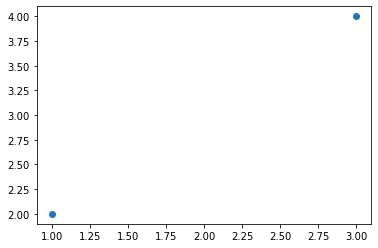

In [4]:
# 绘制点图查看两个点的位置
plt.plot(A[:,0], A[:, 1], 'o')

如果更进一步，我们希望在二维空间中找到一条直线，来拟合这两个点，也就是所谓的构建一个线性回归模型，我们可以设置线性回归方程如下：

<center> $ y = ax + b $ </center>

### 2.转化为优化问题

&emsp;&emsp;上述问题除了可以使用矩阵方法求解以外，还可以将其转化为最优化问题，然后通过求解最优化问题的方法对其进行求解。总的来说，最优化问题的转化分为两步，其一是确定优化数值指标，其二则是确定优化目标函数。在大多数问题中，这二者是相辅相成的，确定了优化的数值指标，也就确定了优化的目标函数。

&emsp;&emsp;如果我们希望通过一条直线拟合二维平面空间上分布的点，最核心的目标，毫无疑问，就是希望方程的预测值和真实值相差较小。假设真实的y值用y表示，预测值用ŷ表示，带入a、b参数，则有数值表示如下：

|$ x^{(i)} $| $ y^{(i)} $ | $ ŷ^{(i)} $ |
| :------:| :------: | :------ |
| 1 | 2 | a+b |
| 3 | 4 | 3a+b |
| ŷ表示 | 对应预测值 | 

<center>$ŷ_1 = 1*a + b  = a + b$</center>      
<center>$ŷ_2 = 3*a + b  = 3a + b$</center>

&emsp;&emsp;而这两个预测值和真实值相差：

<center>$y_1 = 2,  ŷ_1 = a + b, y_1 - ŷ_1 = 2 - a - b$</center>
<center>$y_2 = 4,  ŷ_2 = 3a + b, y_2 - ŷ_1=2 = 4 - 3a - b$</center>

&emsp;&emsp;我们希望ŷ和y尽可能接近，因此我们可以考虑计算上述误差总和，但为了避免正负相消（一部分为正、另一部分为负），在衡量上述两个点的误差总和时，我们使用平方和来进行衡量，而不是简单的求和：

<center>$(y_1 - ŷ_1)^2 + (y_2 - ŷ_2)^2 $</center>     
<center>$=  (2 - a - b)^2 + (4 - 3a - b)^2$</center>          

&emsp;&emsp;上式也就是两个点的预测值和真实值的差值的平方和，也就是所谓的，误差平方和——SSE（Sum of the Squared Errors)。

> 当然，此处我们只带入了（1， 2）和（3， 4）两个点来计算SSE，也就是带入了两条数据来训练y = ax + b这个模型。

> 不难发现，很多时候，机器学习的思想都是相对比较朴素的，很多看似复杂的概念，出发点都是一个非常“简单”的想法，在学习机器学习的过程中，掌握其底层的朴素思想，能够帮助大家在很多场景下活学活用。

&emsp;&emsp;至此，我们已经将原问题转化为了一个最优化问题，接下来我们的问题就是，当a、b取何值时，SSE取值最小？值得注意的是，SSE方程就是我们优化的目标方程（求最小值），因此上述方程也被称为目标函数，同时，SSE代表着真实值和预测值之间的差值（误差平方和），因此也被称为损失函数（预测值距真实值的损失）。

> 换而言之，就是当SSE取值最小时，a、b的取值，就是最终线性回归方程的系数取值。

> 值得注意的是，目标函数和损失函数并不完全等价，但大多数目标函数都由损失函数构成。

### 3.最优化问题的求解方法

&emsp;&emsp;在机器学习领域，大多数优化问题都是围绕目标函数（或者损失函数）进行求解。在上述问题中，我们需要围绕SSE求最小值。SSE是一个关于a和b的二元函数，要求其最小值，需要借助数学工具，也就是所谓的最优化方法。选择优化方法并执行相应计算，可以说是整个建模过程中最核心也是相对较难的部分，很多时候这个过程会直接决定模型的性能。  

- 图形展示目标函数

&emsp;&emsp;为了更好的讨论目标函数（SSE）求最小值的过程，对于上述二元函数来说，我们可以将其展示在三维空间内。此处我们可以使用Python中matplotlib包和Axes3D函数进行三维图像绘制

In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
x = np.arange(-1,3,0.05)
y = np.arange(-1,3,0.05)
a, b = np.meshgrid(x, y)
SSE = (2 - a - b) ** 2 + (4 - 3 * a - b) ** 2

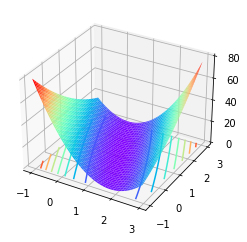

In [4]:
ax = plt.axes(projection='3d')

ax.plot_surface(a, b, SSE, cmap='rainbow')
ax.contour(a, b, SSE, zdir='z', offset=0, cmap="rainbow")  #生成z方向投影，投到x-y平面
plt.show()

- 函数的凹凸性

&emsp;&emsp;初步探索函数图像，不难看出，目标函数是个整体看起来“向下凸”的函数，函数的凹凸性是函数的重要性质，首先我们给出凸函数的一般定义，对于任意一个函数，如果函数f(x)上存在任意两个点，$x_1, x_2$，且      
<center> $ (f(x_1) + f(x_2))/2 >= f((x_1 + x_2)/2) $ </center>     
我们就判定，这个函数是凸函数。 

典型的，例如$y = x^2$，我们可以绘制函数图像如下：

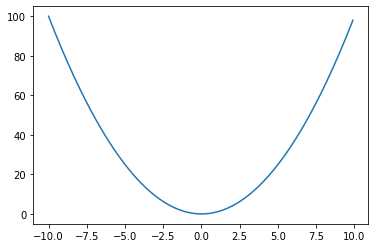

In [7]:
x = np.arange(-10,10,0.1)
y = x ** 2
plt.plot(x, y, '-')
plt.show()

不难看出，函数上任意两个点的y取值的均值都不小于这两个点均值的y的值。

<img src="https://i.loli.net/2021/01/21/AfR1sjbMUVP5c6r.jpg" alt="9" style="zoom:50%;" />

In [48]:
# x1 = 1, x2 = 3
(1 ** 2 + 3 ** 2)/2

5.0

In [49]:
# x1 = 1, x2 = 3
((1+3)/2) ** 2

4.0

而对于一个凸函数来说，全域最小值明显存在，基于凸函数的数学定义，我们可以进一步给出求解上述SSE凸函数最小值的一般方法，也就是著名的最小二乘法

- 凸函数的最小值

&emsp;&emsp;通过$ y = x^2 $函数不难看出，最小值x = 0唯一存在，并且最小值点对应的函数切线与x轴平行，也就是在最小值点，函数的导数为0。这其实也凸函数求解最小值的一般方法：      
a).对于一元函数，如果存在导数为0的点，则该点就是最小值点；      
b).对于多元函数，如果存在某一点，使得函数的各个自变量的偏导数都为0，则该点就是最小值点。      
因此，对于凸函数的最小值求解，最基本的出发点就是寻找导数为0的点。而最小二乘法也是基于偏导函数取值为0联立的方程组进行的求解。

> 从更严格的意义上来说，凸函数的最小值点其实是根据边界点和驻点（导数为0的点）决定，如果没有边界点且没有驻点，则函数没有最小值（例如y=x），如果存在边界点，但没有驻点，则边界点的一侧就是最小值点，如果存在驻点（且左右两边单调性相反），则驻点就是最小值点，例如，对于$ y = x^2 $而言，$ y^{'} = 2x $，2x = 0时x取值为0，也就是0点就是最小值点。      
值得注意的是，驻点也可以说是临界点，但不是拐点，拐点特指左右两边函数凹凸性发生变化的点，切勿和驻点混淆。

> &emsp;&emsp;函数的凹凸性是函数的重要性质，而在使用优化方法围绕目标函数进行求解时，函数本身性质是决定使用哪种优化方法的重要因素，例如函数是否可导、是否连续、函数凹凸性等等。而要判断函数的各种属性，其实都需要经过非常严格的数学证明，也就是说，一般的采用数学优化方法求解的过程，都是先确定函数形式、然后探索函数性质、之后寻找优化方法、最终执行优化算法求解。      
&emsp;&emsp;当然，机器学习建模中的目标函数，大多数时候都是可导的函数，而凹凸性则是影响使用哪种最优化方法的最核心因素。正因如此，凸函数的最优化问题是优化方法的一类重要应用，甚至围绕凸函数，还衍生出了凸优化相关的一大类优化问题分支学课，在机器学习中，我们经常听说的最小二乘法就是求解凸优化问题的重要工具。当然，很多本身不是针对凸函数设计的最优化方法，但鉴于凸函数在求最小值时的优异特性，我们也会在凸优化过程中应用的、例如梯度下降、拟牛顿法等等等等，都是本次课程中重点学习的内容。      

- SSE最小值

而对于SSE来说，此处虽然不做证明，但对于简单线性回归的损失函数，SSE是凸函数，因此，对于$ SSE(a,b) =  (2 - a - b)^2 + (4 - 3a - b)^2 $而言，最小值点就是a、b两个参数求偏导等于0的点

<center>$SSE = (y_1 - ŷ_1)^2 + (y_2 - ŷ_2)^2 $</center>     
<center>$=  (2 - a - b)^2 + (4 - 3a - b)^2$</center> 

<center>$ \frac{\partial{SSE_(a,b)}}{\partial{(a)}} = 0 $</center>           
<center>$ \frac{\partial{SSE_(a,b)}}{\partial{(b)}} = 0 $</center>

其中：

<center>$ \begin{align} \frac{\partial{SSE_{(a,b)}}}{\partial{(a)}}  
& = 2(2-a-b)*(-1) + 2(4-3a-b)*(-3)\\
& = 20a+8b-28 \\
& = 0  \end{align} $</center>

<center>$ \begin{align} \frac{\partial{SSE_{(a,b)}}}{\partial{(b)}}  
& = 2(2-a-b)*(-1) + 2(4-3a-b)*(-1)\\
& = 8a+4b-12 \\ 
& = 0 \end{align} $</center>

<center>$ (1)式 - (2)式*2 可得： 4a-4 = 0，a=1$ <\center>
<center>$ 将a=1带入(2)式 可得： 4b-4 = 0，b=1$ <\center>

<center> $ y = x + 1 $ </center>

In [ ]:
(1,2) (3,4)

> 此外，还可通过(1)式解出一个参数然后带入(2)式进行求解

利用偏导等于0得出的方程组求解线性回归方程参数，就是最小二乘法求解过程。此处我们求得a=1，b=1时，SSE(a,b)取得最小值，也就是（1，1）是目标函数的最小值点。

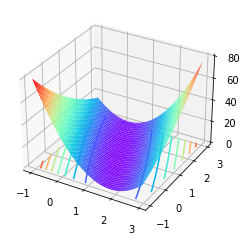

In [77]:
#（1，1）是最小值点
fig = plt.figure()  
ax = plt.axes(projection='3d')

ax.plot_surface(a, b, SSE, cmap='rainbow')
ax.contour(a, b, SSE, zdir='z', offset=0, cmap="rainbow")  
plt.show()

### 4.机器学习建模一般流程

&emsp;&emsp;至此，我们就完成了一个基本的简单线性回归建模过程。当然，对于线性回归来说，有很多种建模方式，哪怕是主流的统计学和机器学习，在利用线性回归进行建模时都有不一样的流程（后续介绍机器学习基础时还会详细介绍）。此处我们是通过一个简单的例子，来介绍机器学习、包括深度学习的利用优化方法建模的一般思想，我们可以将其总结如下：

- Step 1：提出基本模型      
&emsp;&emsp;如本节中，我们试图利用一条直线（y=ax+b）去拟合二维平面空间中的点，这里我们所使用的这条直线，就是我们提出的基本模型。而在后续的深度学习的学习过程中，我们还将看到更为强大、同时也更加通用的神经网络模型。当然，不同的模型能够适用不同的场景，在提出模型时，我们往往会预设一些影响模型结构或者实际判别性能的参数，如简单线性回归中的a和b；

- Step 2：确定损失函数和目标函数

&emsp;&emsp;接下来，围绕建模的目标，我们需要合理设置损失函数，并在此基础之上设置目标函数，当然，在很多情况下，这二者是相同的。例如，在上述简单线性回归中，我们的建模目标就是希望y=ax+b这条直线能够尽可能的拟合(1,2)、(3,4)这两个点，或者说尽可能“穿过”这两个点，因此我们设置了SSE作为损失函数，也就是预测值和真实值的差值平方和。当然，在计算过程中不难发现，SSE是一个包含了a和b这两个变量的方程，因此SSE本身也是一个函数（a和b的二元函数），并且在线性回归中，SSE既是损失函数（用于衡量真实值和预测值差值的函数），同时也是我们的目标函数（接下来需要优化、或者说要求最小值的函数）。这里尤其需要注意的是，损失函数不是模型，而是模型参数所组成的一个函数。

- Step 3：根据目标函数特性，选择优化方法，求解目标函数

&emsp;&emsp;之前提到，目标函数既承载了我们优化的目标（让预测值和真实值尽可能接近），同时也是包含了模型参数的函数，因此完成建模需要确定参数、优化结果需要预测值尽可能接近真实值这两方面需求就统一到了求解目标函数最小值的过程中了，也就是说，当我们围绕目标函数求解最小值时，也就完成了模型参数的求解。当然，这个过程本质上就是一个数学的最优化过程，求解目标函数最小值本质上也就是一个最优化问题，而要解决这个问题，我们就需要灵活适用一些最优化方法。当然，在具体的最优化方法的选择上，函数本身的性质是重要影响因素，也就是说，不同类型、不同性质的函数会影响优化方法的选择。在简单线性回归中，由于目标函数是凸函数，我们根据凸函数性质，判断偏导函数取值为0的点就是最小值点，进而完成a、b的计算（也就是最小二乘法），其实就是通过函数本身的性质进行最优化方法的选取。

## 二、第一个优化算法：最小二乘法

&emsp;&emsp;前面提到，利用优化方法求解目标函数其实是机器学习建模过程中最为核心的环节，因此，我们有必要将围绕上述简单线性回归问题，进一步讨论最小二乘法背后的数学逻辑和优化思想，同时简单探讨数据的矩阵表示方法和基本矩阵运算。虽然最小二乘法并不是主流的深度学习损失函数的优化算法，但从最小二乘法入手了解优化算法背后的数学逻辑，却是非常有必要，同时，线性方程也是构建神经网络模型的基础，因此，我们有必要深入探讨线性模型建模细节以及最基本的优化算法：最小二乘法。

### 1.最小二乘法的代数表示方法

&emsp;&emsp;从更加严格的数学角度出发，最小二乘法有两种表示形式，分别是代数法表示和矩阵表示。我们先看最小二乘法的代数表示方法。

首先，假设多元线性方程有如下形式

<center> $ f(x) = w_1x_1+w_2x_2+...+w_dx_d+b $ </center>

令$w = (w_1,w_2,...w_d)$，$x = (x_1,x_2,...x_d)$，则上式可写为

<center> $ f(x) = w^Tx+b $ </center>

> 在机器学习领域，我们将线性回归自变量系数命名为w，其实是weight的简写，意为自变量的权重。

多元线性回归的最小二乘法的代数法表示较为复杂，此处先考虑简单线性回归的最小二乘法表示形式。在简单线性回归中，w只包含一个分量，x也只包含一个分量，我们令此时的$x_i$就是对应的自变量的取值，此时求解过程如下

优化目标可写为

<center> $ SSE = \sum^m_{i=1}(f(x_i)-y_i)^2 = E_(w,b) $ </center>

通过偏导为0求得最终结果的最小二乘法求解过程为：

<center>$ \begin{align} \frac{\partial{SSE_(w,b)}}{\partial{(w)}} 
& = 2(w\sum^m_{i=1}x^2_i - \sum^m_{i=1}(y_i-b)x_i) = 0  \end{align} $</center>  

$$ \begin{align} \frac{\partial{SSE_(w,b)}}{\partial{(b)}} 
& = 2(mb - \sum^m_{i=1}(y_i-wx_i)) = 0  \end{align}  $$ 

进而可得

<center> $ w = \frac{\sum^m_{i=1}y_i(x_i-\bar{x})
}{\sum^m_{i=1}x^2_i-\frac{1}{m}(\sum^m_{i=1}x_i)^2
} $ </center>

<center> $ b = \frac{1}{m}\sum^m_{i=1}(y_i-wx_i)
$ </center>

其中，$\bar x = \frac{1}{m}\sum^m_{i=1}x_i，x_i$为x的均值，并且$(x_i,y_i)$代表二维空间中的点。针对二维空间内的(1,2)和(3,4)两个点，我们可以使用torch中运算函数手动计算w和b，本部分留作练习，用于同学们课后复习对此前学习的张量基本运算相关知识。   

### 2.最小二乘法的矩阵表示形式

&emsp;&emsp;从《Lesson 4》的矩阵部分内容不难理解，对于线性方程组来说，矩阵表示是一种更加简洁的表示方式，并且对于支持数组运算的torch来说，线性方程组的矩阵表示也更贴近代码的实际书写形式。首先先回顾《Lesson 4》中提到的将上述方程转化为矩阵的过程。线性方程如下

<center> $ 1*a + b = 2 $ <\center> 
<center> $ 3*a + b = 4 $ <\center> 

在转化为矩阵表示的过程中，我们令

$$ A = 
\left [\begin{array}{cccc}
1 &1 \\
3 &1 \\
\end{array}\right]
$$

$$ B =  \left [\begin{array}{cccc}
2 \\
4 \\
\end{array}\right] $$

$$ X^T =  \left [\begin{array}{cccc}
a \\
b \\
\end{array}\right] $$

则原方程组可表示为

$$ A * X^T = B $$

更为一般的情况下，多元线性回归方程为

<center> $ f(x) = w_1x_1+w_2x_2+...+w_dx_d+b $ </center>

令

$$\hat w = (w_1,w_2,...,w_d,b)$$

$$\hat x = (x_1,x_2,...,x_d,1)$$

- $\hat w$：方程系数所组成的向量，并且我们将自变量系数和截距放到了一个向量中，此处$\hat w$就相当于前例中的a、b组成的向量(a,b)；
- $\hat x$：方程自变量和1共同组成的向量；

因此，方程可表示为

$$f(x) = \hat w * \hat x^T$$

另外，我们将所有自变量的值放在一个矩阵中，并且和此前A矩阵类似，为了捕捉截距，添加一列全为1的列在矩阵的末尾，设总共有m组取值，则

$$ X = 
\left [\begin{array}{cccc}
x_{11} &x_{12} &... &x_{1d} &1 \\
x_{21} &x_{22} &... &x_{2d} &1 \\
... &... &... &... &1 \\
x_{m1} &x_{m2} &... &x_{md} &1 \\
\end{array}\right]
$$

对应到前例中的A矩阵，A矩阵就是拥有一个自变量、两个取值的X矩阵。令y为因变量的取值，则有

$$ y =  \left [\begin{array}{cccc}
y_1 \\
y_2 \\
. \\
. \\
. \\
y_m \\
\end{array}\right] $$

此时，SSE可表示为：

$$SSE = ||y - X\hat w^T||_2^2 = (y - X\hat w^T)^T(y - X\hat w^T) = E(\hat w)$$

根据最小二乘法的求解过程，令$E(\hat w)$对$\hat w$求导方程取值为0，有

$$
\begin{aligned}
\frac{E(\hat w)}{\partial{\boldsymbol{\hat w}}} 
&= \frac{\partial{||\boldsymbol{y} - \boldsymbol{X\hat w^T}||_2}^2}{\partial{\boldsymbol{\hat w}}}
\\
&= \frac{\partial(\boldsymbol{y} - \boldsymbol{X\hat w^T})^T(\boldsymbol{y} - \boldsymbol{X\hat w^T})}{\partial{\boldsymbol{\hat w}}}
\\
\\ \because &\ (A-B)^T = A^T - B^T并且(AB)^T = B^T*A^T \\ \\
\therefore& 上式=\frac{\partial(\boldsymbol{y}^T - \boldsymbol{\hat w X^T})(\boldsymbol{y} - \boldsymbol{X\hat w^T})}{\partial{\boldsymbol{\hat w}}}
\\
&=\frac{\partial(\boldsymbol{y}^T\boldsymbol{y} - \boldsymbol{\hat w X^Ty}-\boldsymbol{y}^T\boldsymbol{X \hat w^T} +\boldsymbol{\hat wX^T}\boldsymbol{X\hat w^T})}
{\partial{\boldsymbol{\hat w}}}\\ 
&= 0 - \boldsymbol{X^Ty} - \boldsymbol{X^Ty} + 2\boldsymbol{X^TX\hat w ^T}\\
&= \boldsymbol{X^TX\hat w^T} - \boldsymbol{X^Ty} = 0
\\
&值得注意的是，在矩阵求导中，a为常数，有如下规则：
\begin{equation}
\\\frac{\partial{a}}{\partial{A}} = 0, \ \ \ \frac{\partial{A^TB^TC}}{\partial{A}} = B^TC, \ \ \ \frac{\partial{C^TBA}}{\partial{A}} = B^TC, \ \ \ 
\frac{\partial{A^TBA}}{\partial{A}} = (B+B^T)A
\end{equation}
\end{aligned}
$$ 

进一步可得

$$X^TX\hat w^T = X^Ty$$

要使得此式有解，等价于$X^TX$（也被称为矩阵的交叉乘积crossprod存在逆矩阵，若存在，则可解出

$$\hat w ^T = (X^TX)^{-1}X^Ty$$

### 3.最小二乘法的简单实现

回到最初的例子，不难发现，有如下对应关系：

$$ X = A = 
\left [\begin{array}{cccc}
1 &1 \\
3 &1 \\
\end{array}\right]
$$

$$ y = B =  \left [\begin{array}{cccc}
2 \\
4 \\
\end{array}\right] $$

$$ \hat w ^T = X^T =  \left [\begin{array}{cccc}
a \\
b \\
\end{array}\right] $$

手动实现代码验证最小二乘法

In [63]:
X = A
X

tensor([[1., 1.],
        [3., 1.]])

In [64]:
y = B
y

tensor([[2.],
        [4.]])

In [67]:
X.t()

tensor([[1., 3.],
        [1., 1.]])

In [69]:
w = torch.mm(torch.mm(torch.inverse(torch.mm(X.t(),X)),X.t()),y)

In [70]:
w

tensor([[1.0000],
        [1.0000]])

和此前结果保持一致。当然，最小二乘法作为最优化问题的求解方法，我们可以这么理解w最终取值：当w取值为（1，1）时，自变量为w的SSE函数取得全域最小值。

当然，我们也可以直接调用最小二乘法函数`torch.lstsq(B, A)`进行求解

In [71]:
torch.lstsq(y, X)

torch.return_types.lstsq(
solution=tensor([[1.0000],
        [1.0000]]),
QR=tensor([[-3.1623, -1.2649],
        [ 0.7208, -0.6325]]))

对于lstsq函数来说，第一个参数是因变量张量，第二个参数是自变量张量，并且同时返回结果还包括QR矩阵分解的结果，QR分解也是一种矩阵分解方法，后续在涉及到QR分解内容时会详细进行讲解。

另外，在最小二乘法数学推导过程，涉及到矩阵范数的运算，在PyTorch中，我们使用linalg.norm函数求向量或矩阵的范数

> 注意，老版本教材会推荐使用norm函数进行求解，但实际上新版pytorch已经开始推荐使用linalg.norm替换norm进行范数运算，因此更推荐使用linalg.norm函数

In [101]:
t = torch.tensor([-1, 2.])
t

tensor([-1.,  2.])

In [107]:
# 默认情况，求解L2范数，个元素的平方和开平方
torch.linalg.norm(t)

tensor(2.2361)

In [103]:
torch.sqrt(torch.tensor(5.))

tensor(2.2361)

In [108]:
# 输入参数，求解L1范数，个元素的绝对值之和
torch.linalg.norm(t, 1)

tensor(3.)

### 4.反向验证导数为零

&emsp;&emsp;当然，我们也可以反向验证，看下损失函数SSE在a=1，b=1时偏导数是否都为0。此时就需要借助PyTorch中的autograd模块来进行偏导计算。严格意义上来讲，autograd模块是PyTorch中的自动微分模块，我们可以通过autograd模块中的函数进行微分运算，在神经网络模型中，通过自动微分运算求解梯度是模型优化的核心。关于微分计算梯度进而执行优化的相关方法我们会在后续逐步介绍，此处我们仅适用autograd模块来进行简单的微分计算尝试，也就是对SSE进行偏导计算，判断a、b同时取值为1时偏导是否为0。

&emsp;&emsp;对于目前我们所适用的PyTorch 1.7.1版本来说，我们可以直接在张量Tensor中进行微分运算。目前市面上流通的PyTorch教材有些会介绍Variable类，在进行微分运算时需提前将Tensor类转化为Variable类，但其实在PyTorch 0.4版本以后Tensor就已经不仅仅是一个纯计算的载体，而是可以支持微分运算，Variable的概念被逐渐弱化，可微分性也变成了Tensor的一个基本属性，我们只需要在创建Tensor时，通过设置requires_grad属性为True、规定张量可微分即可。

In [141]:
a = torch.tensor(1.,requires_grad = True)
a

tensor(1., requires_grad=True)

此时a就是一个可微分的张量，requires_grad是a的一个属性，可以查看可以修改。

In [142]:
# 查看可微分性
a.requires_grad

True

In [143]:
# 修改可微分性
a.requires_grad = False

In [144]:
a.requires_grad

False

In [145]:
a.requires_grad = True

In [148]:
b = torch.tensor(1.,requires_grad = True)
b

tensor(1., requires_grad=True)

然后创建损失函数

<center>$(y_1 - ŷ_1)^2 + (y_2 - ŷ_2)^2 $</center>     
<center>$=  (2 - a - b)^2 + (4 - 3a - b)^2$</center>          

In [150]:
sse = torch.pow((2 - a - b), 2) + torch.pow((4 - 3 * a - b), 2)

使用`torch.autograd.grad`进行偏导运算，并输出a=1、b=1时偏导数的值

In [151]:
torch.autograd.grad(sse,[a, b])

(tensor(-0.), tensor(-0.))

至此，也可验证(1,1)是损失函数的最小值点。

- torch.autograd.grad函数      
torch.autograd.grad是通用微分函数，当只输入一个自变量时计算结果就是导数，输入多个自变量时则会计算偏导数。

In [156]:
x = torch.tensor(1.,requires_grad = True)
x

tensor(1., requires_grad=True)

In [157]:
y = x ** 2

In [158]:
# 导数计算结果
torch.autograd.grad(y, x)

(tensor(2.),)

当然，微分计算作为神经网络优化的核心，autograd模块的功能远不仅于此，更多的微分运算，我们将在下一节继续讲解。